In [1]:
import numpy as np
import pyvista as pv
import h5py

import seaborn as sns
import matplotlib.pyplot as plt

import os

import fnmatch

from natsort import natsorted

from tqdm import tqdm

import  pandas as pd

import glob

import scipy

import rasterio

import rioxarray

import open3d as o3d

import cmcrameri.cm as cmc


from mpl_toolkits.axes_grid1 import make_axes_locatable


from scipy.ndimage import gaussian_filter


In [2]:
data_dir = r'/Volumes/Seagate BarraCuda 120/GroundwaterProject-GA/Final_products/'

### Data in vtu format

In [3]:
grid = pv.read(data_dir + 'GAB_keyFields.vtu')

grid.set_active_vectors("MLEvelocityField")

    
grid.set_active_scalars('materialMesh') 

grid.set_active_vectors("MLEvelocityField")

xmin, xmax, ymin, ymax = grid.bounds[0:4]



### Data in h5 format (output from UW model)

File name may have to be changed to the correct velocity field

In [ ]:
# ### create a pyvista mesh

# # define bounding box
# xmin, xmax, ymin, ymax = -955637.8812, 1034362.2443650428, 6342298.2975, 8922298.39436168
# zmin, zmax = -8000.0, 1200.0

# # resolution
# dx, dy, dz = 10e3, 10e3, 100
# # dx, dy, dz = 10e3, 10e3, 50
# Nx, Ny, Nz = int((xmax-xmin)/dx), int((ymax-ymin)/dy), int((zmax-zmin)/dz)



# Xcoords = np.linspace(xmin,xmax,Nx)
# Ycoords = np.linspace(ymin,ymax,Ny)

# grid = pv.StructuredGrid()

# grid.points = h5py.File(glob.glob(dir + 'mesh*')[0], 'r')['vertices'][:]

# grid.dimensions = Nx+1, Ny+1, Nz+1

# grid["MLEvelocityField"] = h5py.File(data_dir + 'MLEvelocityField', 'r')['data'][:]

# grid.set_active_scalars('materialMesh') 
# grid.set_active_vectors("MLEvelocityField")

In [5]:
aspectRatio = (ymax-ymin)/(xmax-xmin)
aspectRatio

1.2964823789290527

In [6]:
df_layers = pd.read_csv(r'/Users/benknight/Documents/GAB_project/GAB_models/UW-GAB_layer_parameters.csv')

df_layers['conductivity (m/day)'] = 10**(np.log10(df_layers['ogia conductivity min (m/day)']/60*60*24) + np.log10(df_layers['ogia conductivity max (m/day)']/60*60*24) /2.)

df_layers['Hydrostratigraphy'] = df_layers.iloc[:,6]


matIndex = str(df_layers['mat index'].iloc[1:-1].values)

layerAttrs = df_layers[['mat index', 'Name Aquifer/Aquitard', 'conductivity (m/day)', "Hydrostratigraphy"]].iloc[1:-1].set_index('Name Aquifer/Aquitard').T.to_dict()


LayerNames = dict(zip(df_layers['mat index'].iloc[1:15].astype(int),df_layers['Name Aquifer/Aquitard'].iloc[1:15]))


/usr/local/Caskroom/miniconda/base/envs/NA/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
raster_dir = r'/Users/benknight/Documents/UW/GAB-Notebooks/data/GAB_surfaces/GeoTiff/'

In [8]:
grid

UnstructuredGrid (0x7f782a2db9a0)
  N Cells:	4723464
  N Points:	4817400
  X Bounds:	-9.556e+05, 1.034e+06
  Y Bounds:	6.342e+06, 8.922e+06
  Z Bounds:	-1.200e+04, 2.660e+03
  N Arrays:	15

In [9]:
def create_surfaces(i):
    ### only run once at beginning
    ### extract the required surfaces
    top = rasterio.open(raster_dir + df_layers['Layer name'].iloc[i] + '.tiff').read(1, masked=True)
    bottom = rasterio.open(raster_dir + df_layers['Layer name'].iloc[i+1] + '.tiff').read(1, masked=True)
    
    tiffFile = rioxarray.open_rasterio(raster_dir + df_layers['Layer name'].iloc[i] + '.tiff')
    
    thickness = np.abs(top.data - bottom.data)
    thickness[thickness == 0] = np.nan
    base_coords = (top - thickness) 
    
    xx, yy = np.meshgrid(tiffFile.x.values, tiffFile.y.values)

    ### extracts the base surface
    points0 = np.array((xx.flatten(), yy.flatten(), base_coords.data.flatten())).T



    points = np.array((xx.flatten(), yy.flatten(), base_coords.data.flatten())).T[~np.isnan(thickness.flatten())]#[::20]

    mask = np.all(np.isin(points0, points), axis=1)


    point_data = points0[mask]
    
    surface = pv.PolyData(point_data)
    
    ### caculates the normals
    pointSet = o3d.geometry.PointCloud()
    pointSet.points = o3d.utility.Vector3dVector(points)
    pointSet.estimate_normals() 
    
    surface['normals'] = np.asarray(pointSet.normals)
    
    return surface

def probe_grid(grid, surface, velocityField):
    ### runs every loop as the velocity field is updated
    
    data = grid.probe(surface)

    
    data['velocity'] = np.array([np.dot(data['normals'][v], data[velocityField][v]) for v in range(len(data[velocityField]))])
    
    
        
    return data


def determine_flux(data):
    ### runs every loop as the velocity field is updated
    

        
    return (data['velocity']*(60*60*24)).sum()


def calcNormals(points):
    pointSet = o3d.geometry.PointCloud()
    pointSet.points = o3d.utility.Vector3dVector(points)
    pointSet.estimate_normals()
    return np.asarray(pointSet.normals)
    



    
    

## Code for all surfaces

In [ ]:
### only run once to create the surfaces
surfaces = [create_surfaces(v) for v in np.arange(1,15,1)]

Select the velocity field in the vtu (grid) file to calculate the velocity across the boundary of the layer

In [ ]:
### MLE velocity field
data0 = [probe_grid(grid, surfaces[v], 'MLEvelocityField') for v in range(len(surfaces))]
flux0 = [determine_flux(data0[v]) for v in range(len(data0))]
flux0

In [ ]:
### MAP velocity field
# data0 = [probe_grid(grid, surfaces[v], 'MAPvelocityField') for v in range(len(surfaces))]
# flux0 = [determine_flux(data0[v]) for v in range(len(data0))]
# flux0

In [ ]:
### ensemble average velocity field
# data2 = [probe_grid(grid, surfaces[v], 'meanVelocityField') for v in range(len(surfaces))]
# flux2 = [determine_flux(data2[v]) for v in range(len(data2))]
# flux2

Plot the data for each layer

In [ ]:
for i in range(len(data)):
    
    
    print('Base ' + df_layers['Name Aquifer/Aquitard'].iloc[i+1], ": " , gaussian_filter(data[i]['velocity']*(60*60*24*365.25), sigma=0.0).sum())
    
    fig, ax = plt.subplots(figsize=(10,10*aspectRatio))
    ax.scatter(data[i].points[:,0], data[i].points[:,1], c=gaussian_filter(data[i]['velocity']*(60*60*24*365.25), sigma=0.0), cmap=cmc.vik, vmin=-1, vmax=1, s=1)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.set_title('Base ' + df_layers['Name Aquifer/Aquitard'].iloc[i+1])

    GAB_outline.boundary.plot(ax=ax, lw=0.7, color='k', ls="--")
    
    plt.show()







### Extract data for 1 layer and save to geotiff

In [10]:
def extract_layer(i, velocityField, saveTiff=False):
    '''
    i : index of layer of interest
    velocityField : velocity field to caculate the flux on
    saveTiff : To save the flux as a geotiff, saves to same directory input tiffs are stored in
    
    '''
    
    
    # for i in range(1, len(df_layers)-2):
    
    print('top: ' + df_layers['Name Aquifer/Aquitard'].iloc[i])
    print('bottom: ' + df_layers['Name Aquifer/Aquitard'].iloc[i+1])

    top = rasterio.open(raster_dir + df_layers['Layer name'].iloc[i] + '.tiff').read(1, masked=True)


    tiffFile = rioxarray.open_rasterio(raster_dir + df_layers['Layer name'].iloc[i] + '.tiff')

    bottom = rasterio.open(raster_dir + df_layers['Layer name'].iloc[i+1] + '.tiff').read(1, masked=True)




    thickness = np.abs(top.data - bottom.data)

    thickness[thickness == 0] = np.nan

    #     thickness[thickness<=0] = np.nan

    base_coords = (top - thickness) #bottom[thickness>=0].shape
    
    xx, yy = np.meshgrid(tiffFile.x.values, tiffFile.y.values)

    points0 = np.array((xx.flatten(), yy.flatten(), base_coords.data.flatten())).T



    points = np.array((xx.flatten(), yy.flatten(), base_coords.data.flatten())).T[~np.isnan(thickness.flatten())]#[::20]

    mask = np.all(np.isin(points0, points), axis=1)


    point_data = points0[mask]
    
    # simply pass the numpy points to the PolyData constructor
    cloud = pv.PolyData(point_data)
    # cloud.plot(point_size=5)
    cloud = grid.probe(cloud)
    
    
    cloud['Normals'] = calcNormals(cloud.points)
    
    
    cloud['velocity'] = np.array([np.dot(cloud['Normals'][v], cloud[velocityField][v]) for v in range(len(cloud[velocityField]))])

    
    values = np.zeros_like(thickness.flatten())
    values[:,] = np.nan
    values

    values[mask] = cloud['velocity']
    


    tiffFile = rasterio.open(raster_dir + df_layers['Layer name'].iloc[i] + '.tiff').read(1, masked=True)

    tiffFile0 = rasterio.open(raster_dir + df_layers['Layer name'].iloc[i] + '.tiff')


    gridded_data = values.reshape(tiffFile.data.shape)



    if saveTiff == True:
        new_dataset = rasterio.open(
        raster_dir+'baseflow-' + df_layers['Name Aquifer/Aquitard'].iloc[i] + '.tiff',
        'w',
        driver='GTiff',
        height=tiffFile.shape[0],
        width=tiffFile.shape[1],
        count=1,
        dtype=v_reshape.dtype,
        nodata=np.nan,
        crs=tiffFile0.crs,
        transform= tiffFile0.transform)


        new_dataset.write(v_reshape, 1)

        new_dataset.close()
        
        print('saved ' + 'baseflow-' + df_layers['Name Aquifer/Aquitard'].iloc[i] + '.tiff')
        
    else:
        pass
    
    
    return cloud, gridded_data



In [11]:
cloud, gridded_data = extract_layer(i=5, velocityField='MLEvelocityField')



top: Cadna-owie-Hooray
bottom: Westbourne


In [12]:
import fiona
import geopandas as gpd


GAB_outline = gpd.read_file('/Volumes/Seagate BarraCuda 120/GroundwaterProject-GA/GA_GAB_project/GAB_boundary_z55/GAB_boundary_z55.shp')

AusStates = gpd.read_file('/Volumes/Seagate BarraCuda 120/GroundwaterProject-GA/GA_GAB_project/STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp')



ERROR - 2022-05-27 11:16:26,827 - collection - PROJ: proj_identify: /usr/local/Caskroom/miniconda/base/envs/NA/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
INFO - 2022-05-27 11:16:26,838 - collection - Failed to auto identify EPSG: 7
ERROR - 2022-05-27 11:16:27,008 - collection - PROJ: proj_identify: /usr/local/Caskroom/miniconda/base/envs/NA/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


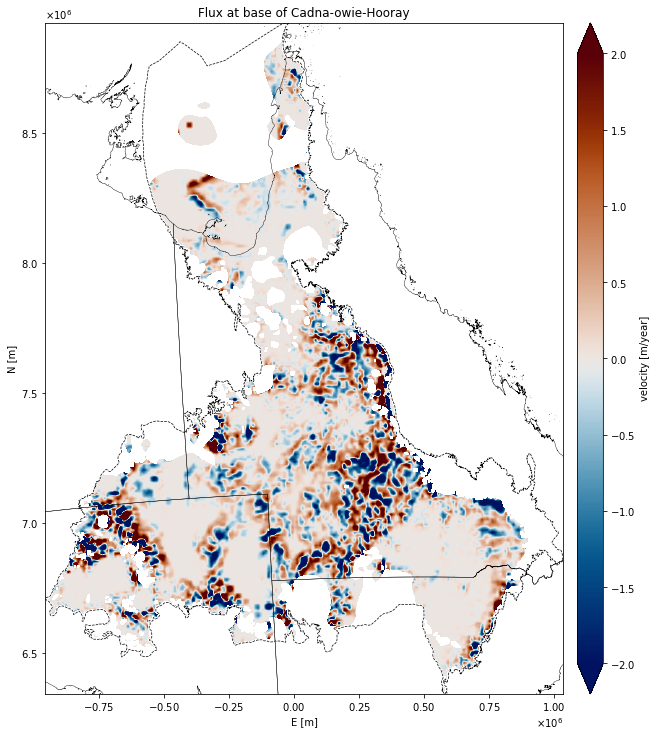

In [14]:
from scipy.ndimage import gaussian_filter

fig, ax = plt.subplots(figsize=(10,10*aspectRatio))

# data = ax.scatter(cloud.points[:,0], cloud.points[:,1], c=gaussian_filter(cloud['velocity']*(60*60*24*365.25), sigma=0.0), cmap=cmc.vik, vmin=-1, vmax=1, s=1)
data = ax.imshow(gridded_data*(60*60*24*365.25), extent=grid.bounds[0:4], vmin=-2, vmax=2, cmap=cmc.vik )


divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=0.2)
fig.add_axes(cax)
cb0 = fig.colorbar(data, cax=cax, extend='both')
cb0.ax.set_ylabel('velocity [m/year]')

cb0.formatter.set_useMathText(True)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

GAB_outline.boundary.plot(ax=ax, lw=0.7, color='k', ls="--")
AusStates0 = AusStates.to_crs(28355)
AusStates0.boundary.plot(lw=0.4, color='k', ax=ax)

ax.set_title('Flux at base of Cadna-owie-Hooray')


ax.xaxis.major.formatter._useMathText = True

ax.yaxis.major.formatter._useMathText = True

ax.set_ylabel("N [m]")

ax.set_xlabel("E [m]")

rect = fig.patch

rect.set_facecolor("white")

# plt.savefig(save_data +'COH-velatBase-EA.png', bbox_inches='tight', dpi=300)
